In [67]:
import matplotlib.pyplot as plt
import cv2
import pytesseract as pt
import numpy as np
from deskew import determine_skew
import skimage.transform as sit
from skimage.util import img_as_ubyte
import re 

import spacy
load_model = spacy.load("pl_core_news_sm")

pt.pytesseract.tesseract_cmd = r'C:/Program Files\Tesseract-OCR\tesseract.exe'

Zapisanie kodów kolorów do zmiennych

In [68]:
red = '\033[91m'
green = '\033[93m'+'\033[92m'
blue = '\033[96m'
yellow = '\033[93m'
black = '\033[90m'

Wyrażenia regularne wykorzystywane w poszukiwaniu liczb i jednostek miary w przepisach oraz lista słów strukturyzujących przepis

In [156]:
number_tokens = "\d+,*\/*-*\d*"
quantity_tokens = " l |litr|dag|\|| g |kg|łyżka|łyżki|łyżek|łyżeczka|łyżeczki|łyżeczek|szklanka|szklanki|szklanek|szkdanki| mi |bulwa|bulwy|kromka|kromki|kromek|ząbek|ząbków|ząbki| ml |szczypta|tyżka|tyżek|tyżki|tyżeczka|tyżeczek|tyżeczki|natka| I |Krążek| m "
structure_words = "zł godz składniki sposób czas wykonanie porcji błonnika błonnik".split()

# Przygtowanie zdjęć pod OCR

Zdjęcia przepisów, na których będą wykonywane operacje

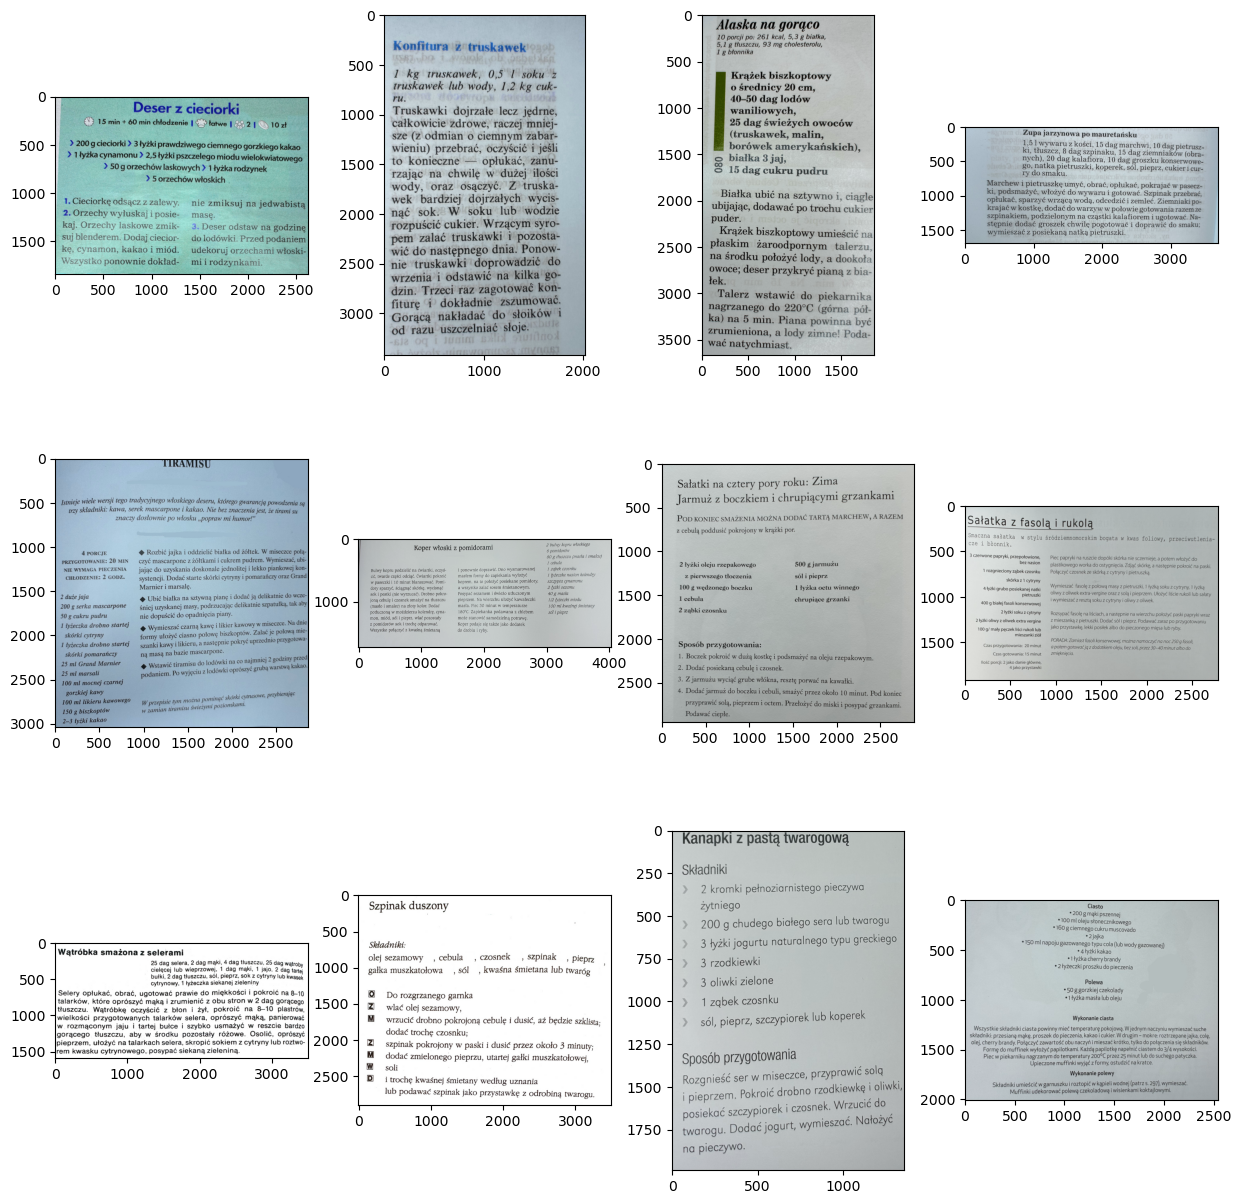

In [70]:
plt.figure(figsize = (15,15))
for i in range(1,13):
    path = 'photos/t'+str(i)+'.jpg'
    img = cv2.imread(path)
    plt.subplot(3,4,i)
    plt.imshow(img, cmap='gray')

Funkcja zmieniająca rozmiar zdjęcia pod OCR'a. 
Optymalna wysokość liter dla tesseract'a to 32px. Tesseract posiada funkcję zwracającą dane o zdjęciu, między innymi wielkość ramek ograniczających słów. Funkcja oblicza średnią wysokość takiej ramki dla zdjecia, następnie oblicza współczynnik skalowania i zmienia rozmiar zdjęcia zgodnie z nim. 

Do powiększenia zdjęć używa interpolacji INTER_CUBIC. Zapewnia lepszą jakość zdjęc w porównaniu z innymi, jednak jest wolniejsza.

Do pomniejszania używa interpolacji INTER_AREA, która pozwala uniknąć artefaktów aliasingu.

Konfiguracja "--psm 1 w tesseract pozwala przeczytać kolumny tekstu jako osobne strony, dzięki czemu się nie mieszają.

In [71]:
def optimal_resize(img):
    boxes = pt.image_to_data(img, config='--psm 1', output_type = "data.frame")
    median_height = np.median(boxes["height"])
    target_height = 32
    scale_factor = target_height / median_height
    skip_percentage = 0.07
    if(scale_factor > 1 - skip_percentage and scale_factor < 1 + skip_percentage):
        return img
    if(scale_factor > 1.0):
        interpolation = cv2.INTER_CUBIC
    else:
        interpolation = cv2.INTER_AREA
    return cv2.resize(img, None, fx = scale_factor, fy = scale_factor, interpolation = interpolation)

Funkcja przygotowująca zdjęcia do OCR'a. Na początku zmienia rozmiar zdjęcia wyżej zdefiniowaną funkcją. Następnie zmienia kolory na odcienie szarości w przygotowaniu do binaryzacji. Następnie usuwany jest szum typu pieprz za pomocą filtru zamknięcia. Rozmycie Gaussowskie usuwa szum. Zdjęcie jest binaryzowane. Tesseract robi to przed czytaniem tekstu, jednak wyniki potrafią być suboptymalne. Następnie usuwane jest przekrzywienie obrazu. Tesseract jest w stanie wykryć obrót obrazu o 90,180 i 270 stopni, jednak nie radzi sobie z drobnymi odchyleniami, którą wpływają na wyniki odczytywania tekstu. Ostateczny obraz zapisywany jest w formie bitowej bezznakowej

In [72]:
def preprocess(image):
    img = optimal_resize(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kernel = np.ones((1,1), np.uint8)
    img = cv2.erode(img, kernel, iterations=1)
    img = cv2.dilate(img, kernel, iterations=1)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    angle = determine_skew(img)
    img = sit.rotate(img, angle, resize=True, cval = 1)
    img = img_as_ubyte(img)
    return img

Wynik zastosowania funkcji na wsyzstkich zdjęciach

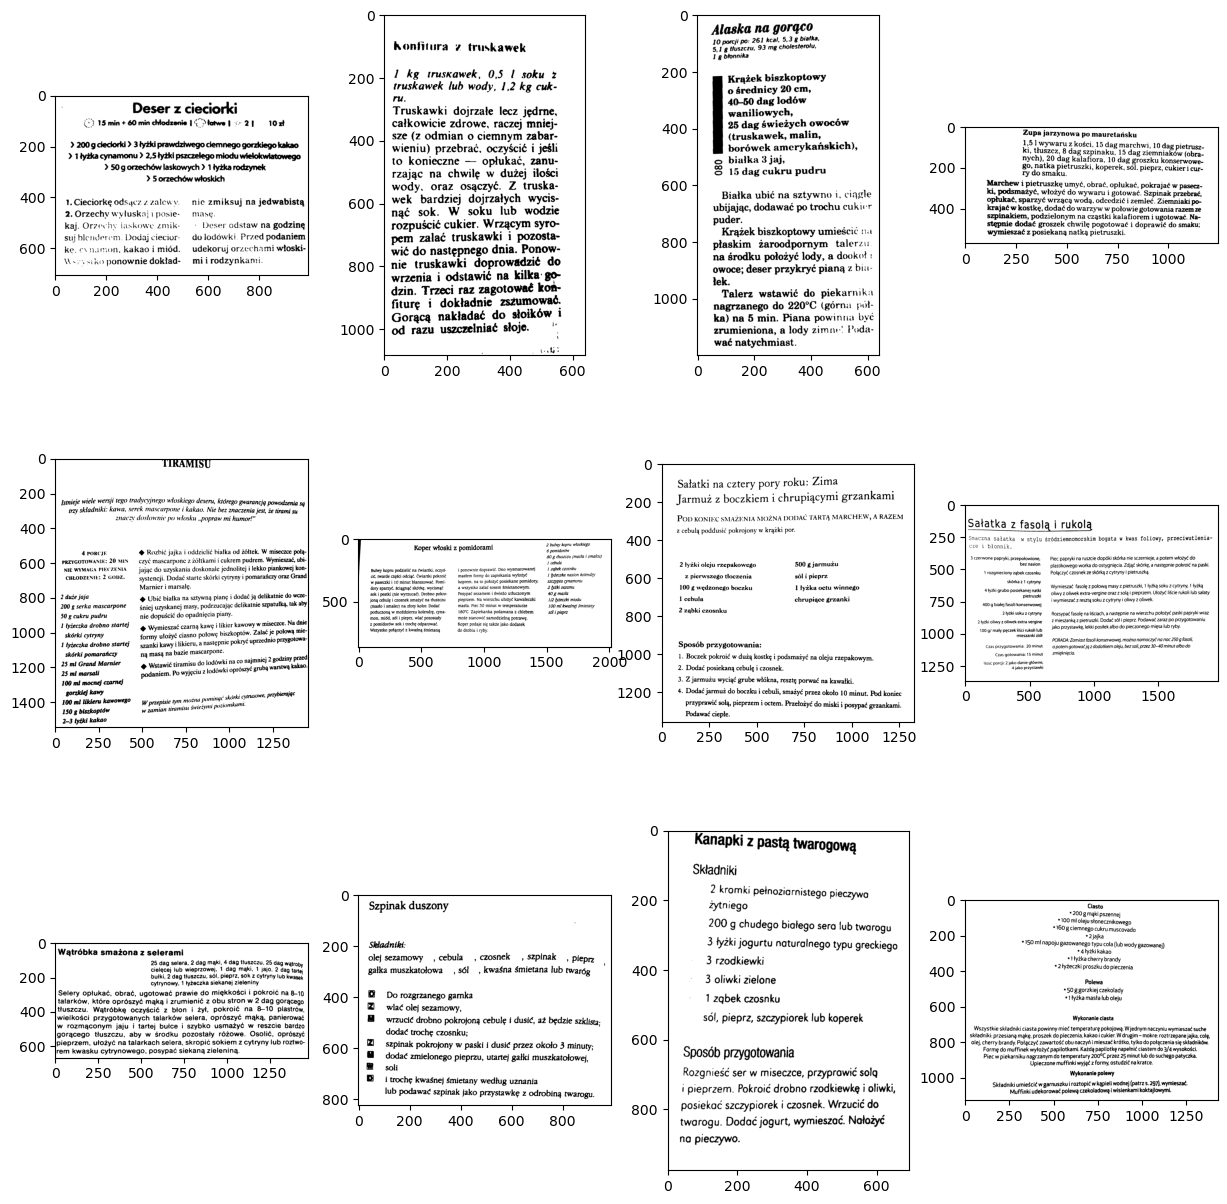

In [73]:
plt.figure(figsize = (15,15))
for i in range(1,13):
    path = 'photos/t'+str(i)+'.jpg'
    img = cv2.imread(path)
    img = preprocess(img)
    plt.subplot(3,4,i)
    plt.imshow(img, cmap='gray')

# Przygotowanie tekstu ze zdjęcia do przetwarzania

#### Rozdzielenie słów do listy

Rozdzielenie na podstawie spacji oraz oddzielenie liczb i jednostek miary od innych słów w przypadkach gdy tesseract przeczytał je razem. Sklejenie słów przeniesionych do nowej linii, oraz usunięcie znaków interpunkcyjnych z początku i końca każdego słowa.

In [74]:
def split_words_from_text(txt):
    glued_words = []
    words = txt.split()
    remainder = ""
    for word in words:
        word = word.strip(" ,./\\*\(\):;?!\'\"\[\]_”„=<>")
        word = " "+word+" "
        number = re.findall(number_tokens, word)
        word = re.sub(number_tokens, "", word)
        quantity = re.findall(quantity_tokens, word)
        other = re.sub(quantity_tokens, "", word)
        other = other.strip()
        if len(remainder) > 0:
            glued_words.append((remainder+other).strip("- ,./\\*\(\):;?!\'\"\[\]_”„=<>"))
            remainder = ""
            other = ""
        if len(number) > 0:
            glued_words.append(number[0])
        if len(quantity) > 0:
            glued_words.append(quantity[0].strip())
        if len(other) > 0:
            if other[-1] == "-":
                remainder = other[0:-1]
                continue
            glued_words.append(other.strip("- ,./\\*\(\):;?!\'\"\[\]_”„=<>”"))
    return glued_words

Działanie na przykładowym zdjęciu

In [75]:
example_image =  cv2.imread("photos/t4.jpg")
processed = preprocess(example_image)
text = pt.image_to_string(processed, lang = "pol", config='--psm 1')
print(text)
split_text = split_words_from_text(text)
print("Tekst po rozdzieleniu: ")
print("")
for word in split_text:
    print(word, end = " ")

Zupa jarzynowa po mauretańsku

1,5 | wywaru z kości, 15 dag marchwi, 10 dag pietrusz-
ki, tłuszcz, 8 dag szpinaku, 15 dag ziemniaków (obra-
nych), 20 dag kałafiora, 10 dag groszku konserwowe-
go, natka pietruszki, koperek, sól. pieprz, cukier i cur-
ry do smaku.
Marchew i pietruszkę umyć, obrać, opłukać, pokrajać w pasecz-
ki, podsmażyć, włożyć do wywaru i gotować. Szpinak przebrać,
opłukać, sparzyć wrzącą wodą, odcedzić i zemleć. Ziemniaki po-
krajać w kostkę, dodać do warzyw w połowie gotowania razem ze
szpinakiem, podzielonym na cząstki kalafiorem i ugotować. Na-
stępnie dodać groszek chwilę pogotować i doprawić do smaku;
wymieszać z posiekaną natką pietruszki.

Tekst po rozdzieleniu: 

Zupa jarzynowa po mauretańsku 1,5 | wywaru z kości 15 dag marchwi 10 dag pietruszki tłuszcz 8 dag szpinaku 15 dag ziemniaków obranych 20 dag kałafiora 10 dag groszku konserwowego natka pietruszki koperek sól pieprz cukier i curry do smaku Marchew i pietruszkę umyć obrać opłukać pokrajać w paseczki po

#### Wczytanie nazwy dania z tekstu

Wzięcie pierwszej niepustej linii z tekstu i przypisanie jej jako nazwy dania

In [76]:
def get_dish_name(text):
    lines = text.split("\n")
    name = ""
    for line in lines:
        if line != "":
            name = line
            break
    return name

In [77]:
dish_name = get_dish_name(text)
print(dish_name)

Zupa jarzynowa po mauretańsku


# Zawężenie obszaru poszukiwań

#### Funkcje klasyfikujące słowa na liczby, jednostki miary, zwykłe słowa i słowa które na pewno nie znajdują się w składnikach

Za pomocą wyrażenia regularnego zdefiniowanego na samym początku dokumentu, funkcja sprawdza czy dane jej słowo to liczba lub zakres liczbowy

In [78]:
def is_number(word):
    if re.search(number_tokens, word):
        return True
    return False

Za pomocą drugiego wyrażenia, również z początku ddokumentu, funkcja sprawdza czy podane słowo jest jednostką miary lub ssłowem które powinno być jednostką miary, jednak zostało źle przeczytane przez OCR.

In [151]:
def is_quantity(word):
    if re.search(quantity_tokens, " "+word+" "):
        return True
    return False

Funkcja sprawdza czy słowo nie jest stop słowem lub słowem które na pewno nie znajduje się w składnikach - czasownikiem lub jednostką czasu, walutą itd.

In [80]:
def is_useful(word):
    useless = "min zł godz. kcal cm godz minut © € > : - + — £ C popraw hi rami oj |".split()
    stops = ['a', 'aby', 'ach', 'acz', 'aczkolwiek', 'aj', 'albo', 'ale', 'alez', 'ależ', 'ani', 'az', 'aż', 'bardziej', 'bardzo', 'beda', 'bedzie', 'bez', 'deda', 'będą', 'bede', 'będę', 'będzie', 'bo', 'bowiem', 'by', 'byc', 'być', 'byl', 'byla', 'byli', 'bylo', 'byly', 'był', 'była', 'było', 'były', 'bynajmniej', 'cala', 'cali', 'caly', 'cała', 'cały', 'ci', 'cie', 'ciebie', 'cię', 'co', 'cokolwiek', 'cos', 'coś', 'czasami', 'czasem', 'czemu', 'czy', 'czyli', 'daleko', 'dla', 'dlaczego', 'dlatego', 'do', 'dobrze', 'dokad', 'dokąd', 'dosc', 'dość', 'duzo', 'dużo', 'dwa', 'dwaj', 'dwie', 'dwoje', 'dzis', 'dzisiaj', 'dziś', 'gdy', 'gdyby', 'gdyz', 'gdyż', 'gdzie', 'gdziekolwiek', 'gdzies', 'gdzieś', 'go', 'i', 'ich', 'ile', 'im', 'inna', 'inne', 'inny', 'innych', 'iz', 'iż', 'ja', 'jak', 'jakas', 'jakaś', 'jakby', 'jaki', 'jakichs', 'jakichś', 'jakie', 'jakis', 'jakiś', 'jakiz', 'jakiż', 'jakkolwiek', 'jako', 'jakos', 'jakoś', 'ją', 'je', 'jeden', 'jedna', 'jednak', 'jednakze', 'jednakże', 'jedno', 'jego', 'jej', 'jemu', 'jesli', 'jest', 'jestem', 'jeszcze', 'jeśli', 'jezeli', 'jeżeli', 'juz', 'już', 'kazdy', 'każdy', 'kiedy', 'kilka', 'kims', 'kimś', 'kto', 'ktokolwiek', 'ktora', 'ktore', 'ktorego', 'ktorej', 'ktory', 'ktorych', 'ktorym', 'ktorzy', 'ktos', 'ktoś', 'która', 'które', 'którego', 'której', 'który', 'których', 'którym', 'którzy', 'ku', 'lat', 'lecz', 'lub', 'ma', 'mają', 'mało', 'mam', 'mi', 'miedzy', 'między', 'mimo', 'mna', 'mną', 'mnie', 'moga', 'mogą', 'moi', 'moim', 'moj', 'moja', 'moje', 'moze', 'mozliwe', 'mozna', 'może', 'możliwe', 'można', 'mój', 'mu', 'musi', 'my', 'na', 'nad', 'nam', 'nami', 'nas', 'nasi', 'nasz', 'nasza', 'nasze', 'naszego', 'naszych', 'natomiast', 'natychmiast', 'nawet', 'nia', 'nią', 'nic', 'nich', 'nie', 'niech', 'niego', 'niej', 'niemu', 'nigdy', 'nim', 'nimi', 'niz', 'niż', 'no', 'o', 'obok', 'od', 'około', 'on', 'ona', 'one', 'oni', 'ono', 'oraz', 'oto', 'owszem', 'pan', 'pana', 'pani', 'po', 'pod', 'podczas', 'pomimo', 'ponad', 'poniewaz', 'ponieważ', 'powinien', 'powinna', 'powinni', 'powinno', 'poza', 'prawie', 'przeciez', 'przecież', 'przed', 'przede', 'przedtem', 'przez', 'przy', 'roku', 'rowniez', 'również', 'sam', 'sama', 'są', 'sie', 'się', 'skad', 'skąd', 'soba', 'sobą', 'sobie', 'sposob', 'sposób', 'swoje', 'ta', 'tak', 'taka', 'taki', 'takie', 'takze', 'także', 'tam', 'te', 'tego', 'tej', 'ten', 'teraz', 'też', 'to', 'toba', 'tobą', 'tobie', 'totez', 'toteż', 'totobą', 'trzeba', 'tu', 'tutaj', 'twoi', 'twoim', 'twoj', 'twoja', 'twoje', 'twój', 'twym', 'ty', 'tych', 'tylko', 'tym', 'u', 'w', 'wam', 'wami', 'was', 'wasz', 'wasza', 'wasze', 'we', 'według', 'wiele', 'wielu', 'więc', 'więcej', 'wlasnie', 'właśnie', 'wszyscy', 'wszystkich', 'wszystkie', 'wszystkim', 'wszystko', 'wtedy', 'wy', 'z', 'za', 'zaden', 'zadna', 'zadne', 'zadnych', 'zapewne', 'zawsze', 'ze', 'zeby', 'zeznowu', 'zł', 'znow', 'znowu', 'znów', 'zostal', 'został', 'żaden', 'żadna', 'żadne', 'żadnych', 'że', 'żeby']
    if word.lower() in useless or word.lower() in stops:
        return False
    word_loaded = load_model(word)
    if len(word_loaded) > 0 and word_loaded[0].pos_ == "VERB":
        return False
    return True

Funkcja sprawdza czy słowo jest czasownikiem lub słowem, które na pewno nie jest wśród składników. Omija słowa z whitelisty, które pakiet spacy błędnie interpretuje jako czasowniki

In [81]:
def is_wrong(word):
    wrong = "min zł godz. kcal godz minut € > : - + — £ C popraw hi rami oj ń razem dodać".split()
    whitelist = "pomarańczy marsali pieczywa sera selera pieczywa".split()
    if re.search(quantity_tokens, word.lower()) or word.lower() in whitelist:
        return False
    if word.lower() in wrong:
        return True
    word_loaded = load_model(word)
    if len(word_loaded) > 0 and word_loaded[0].pos_ == "VERB":
        return True
    return False

#### Zaznaczenie słów sugerujących składniki

Używając powyższych funkcji klasyfikujących, w osobnej liście zapisywane są wartości True w miejscach gdzie w tekście znajdują się słowa sugerujące składniki

In [82]:
def mark_words_true(split_text):
    trues = [None] * len(split_text)
    for i in range(len(split_text)):
        word = split_text[i]
        if is_number(word):
            trues[i] = True
        if is_quantity(word):
            trues[i] = True
        if is_useful(word):
            trues[i] = True
    return trues

#### Zaznaczenie słów, które na pewno nie należą do składników

Za pomocą funkcji testujących, wyławiane są wszystkie słowa, które na pewno nie należą do składników. W osobnej liście, na ich indexach wstawiane są wartości False. Taka lista jest zwracana.

In [83]:
def mark_words_false(split_text):
    falses = [None] * len(split_text)
    for i in range(len(split_text)):
        word = split_text[i]
        if is_wrong(word):
            falses[i] = False
    return falses

#### Propagacja wartości 

W zależności od podanego argumentu, funkcja wywołuje zaznaczenie słów ,,składnikowych" lub ,,złych". Następnie propaguje uzyskaną wartość na prawo i lewo od zaznaczonych już słów.

In [84]:
def propagade(split_text, neighbours, value_given):
    if value_given == True:
        marked_words = mark_words_true(split_text) 
    else:
        marked_words = mark_words_false(split_text) 
    indices = [index for index, value in enumerate(marked_words) if value is value_given]
    for i in indices:
        for j in range(1,neighbours+1):
            if i-j >= 0:
                marked_words[i-j] = value_given
            if i+j < len(marked_words):
                marked_words[i+j] = value_given
    return marked_words

#### Działanie na przykładowym zdjęciu

Rozdzielony tekst z przykładowego zdjęcia

In [85]:
for word in split_text:
    print(word, end = " ")

Zupa jarzynowa po mauretańsku 1,5 | wywaru z kości 15 dag marchwi 10 dag pietruszki tłuszcz 8 dag szpinaku 15 dag ziemniaków obranych 20 dag kałafiora 10 dag groszku konserwowego natka pietruszki koperek sól pieprz cukier i curry do smaku Marchew i pietruszkę umyć obrać opłukać pokrajać w paseczki podsmażyć włożyć do wywaru i gotować Szpinak przebrać opłukać sparzyć wrzącą wodą odcedzić i zemleć Ziemniaki pokrajać w kostkę dodać do warzyw w połowie gotowania razem ze szpinakiem podzielonym na cząstki kalafiorem i ugotować Następnie dodać groszek chwilę pogotować i doprawić do smaku wymieszać z posiekaną natką pietruszki 

Zaznaczenie słów ,,składnikowych"

In [86]:
true_words = mark_words_true(split_text)
for i in range(len(split_text)):
    if true_words[i] == True:
        print(green + split_text[i], end=" ")
    else:
        print(black + split_text[i], end=" ")

Zupa jarzynowa po mauretańsku 1,5 | wywaru z kości 15 dag marchwi 10 dag pietruszki tłuszcz 8 dag szpinaku 15 dag ziemniaków obranych 20 dag kałafiora 10 dag groszku konserwowego natka pietruszki koperek sól pieprz cukier i curry do smaku Marchew i pietruszkę umyć obrać opłukać pokrajać w paseczki podsmażyć włożyć do wywaru i gotować Szpinak przebrać opłukać sparzyć wrzącą wodą odcedzić i zemleć Ziemniaki pokrajać w kostkę dodać do warzyw w połowie gotowania razem ze szpinakiem podzielonym na cząstki kalafiorem i ugotować Następnie dodać groszek chwilę pogotować i doprawić do smaku wymieszać z posiekaną natką pietruszki 

Propagacja wartości True. W przypadku przepisów najlepiej sprawdza się wartość 1, dla propagacji zarówno wartości True jak False.

In [87]:
prop_true = propagade(split_text, 1, True)
for i in range(len(split_text)):
    if true_words[i] == True:
        print(green + split_text[i], end=" ")
    elif prop_true[i] == True:
        print(blue + split_text[i], end=" ")
    else:
        print(black + split_text[i], end=" ")

Zupa jarzynowa po mauretańsku 1,5 | wywaru z kości 15 dag marchwi 10 dag pietruszki tłuszcz 8 dag szpinaku 15 dag ziemniaków obranych 20 dag kałafiora 10 dag groszku konserwowego natka pietruszki koperek sól pieprz cukier i curry do smaku Marchew i pietruszkę umyć obrać opłukać pokrajać w paseczki podsmażyć włożyć do wywaru i gotować Szpinak przebrać opłukać sparzyć wrzącą wodą odcedzić i zemleć Ziemniaki pokrajać w kostkę dodać do warzyw w połowie gotowania razem ze szpinakiem podzielonym na cząstki kalafiorem i ugotować Następnie dodać groszek chwilę pogotować i doprawić do smaku wymieszać z posiekaną natką pietruszki 

Zaznaczenie słów ,,złych"

In [88]:
false_words = mark_words_false(split_text)
for i in range(len(split_text)):
    color = black
    if true_words[i] == True:
        color = green
    elif prop_true[i] == True:
        color = blue
    if false_words[i] == False:
        color = red
    print(color + split_text[i], end=" ")

Zupa jarzynowa po mauretańsku 1,5 | wywaru z kości 15 dag marchwi 10 dag pietruszki tłuszcz 8 dag szpinaku 15 dag ziemniaków obranych 20 dag kałafiora 10 dag groszku konserwowego natka pietruszki koperek sól pieprz cukier i curry do smaku Marchew i pietruszkę umyć obrać opłukać pokrajać w paseczki podsmażyć włożyć do wywaru i gotować Szpinak przebrać opłukać sparzyć wrzącą wodą odcedzić i zemleć Ziemniaki pokrajać w kostkę dodać do warzyw w połowie gotowania razem ze szpinakiem podzielonym na cząstki kalafiorem i ugotować Następnie dodać groszek chwilę pogotować i doprawić do smaku wymieszać z posiekaną natką pietruszki 

Propagacja wartości False

In [89]:
prop_false = propagade(split_text, 1, False)
for i in range(len(split_text)):
    color = black
    if true_words[i] == True:
        color = green
    elif prop_true[i] == True:
        color = blue
    if false_words[i] == False:
        color = red
    elif prop_false[i] == False:
        color = yellow
    print(color + split_text[i], end=" ")

Zupa jarzynowa po mauretańsku 1,5 | wywaru z kości 15 dag marchwi 10 dag pietruszki tłuszcz 8 dag szpinaku 15 dag ziemniaków obranych 20 dag kałafiora 10 dag groszku konserwowego natka pietruszki koperek sól pieprz cukier i curry do smaku Marchew i pietruszkę umyć obrać opłukać pokrajać w paseczki podsmażyć włożyć do wywaru i gotować Szpinak przebrać opłukać sparzyć wrzącą wodą odcedzić i zemleć Ziemniaki pokrajać w kostkę dodać do warzyw w połowie gotowania razem ze szpinakiem podzielonym na cząstki kalafiorem i ugotować Następnie dodać groszek chwilę pogotować i doprawić do smaku wymieszać z posiekaną natką pietruszki 

#### Złożenie dwóch masek w jedną

Mając dwie maski z zaznaczonymi i rozpropagowanymi wartościami, można je złożyć w jedną, aby następnie nałożyć ją na tekst. Maska wynikowa jest maską wartości False, do której w wolne miejsca zostają wpisane wartości True zgodnie z indeksami maski z wartościami True.

In [90]:
def merge_masks(mask_true, mask_false):
    mask = mask_false
    for i, val in enumerate(mask):
        if val != False:
            if mask_true[i] == True:
                mask[i] = True
            else:
                mask[i] = ""
    return mask

Dla powyższego przykładu

In [91]:
final_mask = merge_masks(prop_true, prop_false)
for i in range(len(split_text)):
    color = black
    if final_mask[i] == True:
        color = green
    elif final_mask[i] == False:
        color = red
    print(color + split_text[i], end=" ")

Zupa jarzynowa po mauretańsku 1,5 | wywaru z kości 15 dag marchwi 10 dag pietruszki tłuszcz 8 dag szpinaku 15 dag ziemniaków obranych 20 dag kałafiora 10 dag groszku konserwowego natka pietruszki koperek sól pieprz cukier i curry do smaku Marchew i pietruszkę umyć obrać opłukać pokrajać w paseczki podsmażyć włożyć do wywaru i gotować Szpinak przebrać opłukać sparzyć wrzącą wodą odcedzić i zemleć Ziemniaki pokrajać w kostkę dodać do warzyw w połowie gotowania razem ze szpinakiem podzielonym na cząstki kalafiorem i ugotować Następnie dodać groszek chwilę pogotować i doprawić do smaku wymieszać z posiekaną natką pietruszki 

#### Wyszukanie najdłuższego ciągu wartości True

Funkcja poszukuje w podanej liście najdłuższego ciągu zadanego elementu. Zwracane są długość takiego ciągu oraz jego indeks początkowy.

In [92]:
def find_longest_sequence(list_of_values, value):
    max_sequence = 0
    max_index = 0
    current_sequence = 0
    current_index = 0
    for i, val in enumerate(list_of_values):
        if val == value:
            if current_sequence == 0:
                current_index = i
            current_sequence += 1
        else:
            current_sequence = 0
        if current_sequence > max_sequence:
            max_sequence = current_sequence
            max_index = current_index
    return max_sequence, max_index

Utworzenie wycinka tekstu o zadanym przedziale z listy słów. Wykorzystane w połączeniu z najdłuższym ciągiem daje zawężony obszar poszukiwań.

In [93]:
def get_text_in_range(split_text, start_index, end_index):
    output_text = ""
    for i in range(start_index, end_index):
        if i != start_index:
            output_text += " "
        output_text += split_text[i]
    return output_text

Użycie funkcji dla stworzonej maski i wypisanie wartości tekstowych odpowiadającym indeksami najdłuższemu ciągowi

In [94]:
sequence_length, beggining_index = find_longest_sequence(final_mask, True)
cut_down_text = get_text_in_range(split_text, beggining_index, sequence_length+beggining_index)
print(cut_down_text)

Zupa jarzynowa po mauretańsku 1,5 | wywaru z kości 15 dag marchwi 10 dag pietruszki tłuszcz 8 dag szpinaku 15 dag ziemniaków obranych 20 dag kałafiora 10 dag groszku konserwowego natka pietruszki koperek sól pieprz cukier i curry do smaku Marchew i


#### Przycięcie początku i końca tekstu

W otrzymanym tekście znajdują się już głównie składniki, jednak dalej nie są one jedynymi słowami. Aby jeszcze bardziej zawęzić obszardo przetwarzania, z tekstu ucinane są: jednostki czasu, nazwa dania i słowa strukturyzujące przepis, takie jak „Składniki", „Sposób przygotowania" czy „czas przygotowania" oraz informacje znajdujące się przed/za nimi.

In [95]:
def trim_unnecessary(aproximate_text, name, characteristic_words):
    aproximate_text = aproximate_text.replace(name+" ", "")
    good = aproximate_text
    for ch_word in characteristic_words:
        parts =  re.split(ch_word, good, flags=re.IGNORECASE)
        if len(parts) > 1:
            good = max(parts, key = len).strip()
    return good

Dla używanego dotychczas przykładu usuwana jest jedynie nazwa dania. Widać niestety pozostałości na końcu tekstu.

In [96]:
final_output = trim_unnecessary(cut_down_text, dish_name, structure_words)
print(final_output)

1,5 | wywaru z kości 15 dag marchwi 10 dag pietruszki tłuszcz 8 dag szpinaku 15 dag ziemniaków obranych 20 dag kałafiora 10 dag groszku konserwowego natka pietruszki koperek sól pieprz cukier i curry do smaku Marchew i


# Analiza składniowa otrzymanych składników

Z otrzymanego tekstu, który jest głównie składnikami przepisu, tworzona jest lista dla każdego z nich. Taka lista zawiera 3 elementy typu string: ilość liczbowa składnika, jednostka miary oraz sama nazwa składnika. Wszystkie takie listy są wkładane po kolei do listy składników.

In [153]:
def dict_empty(diction):
    for key in diction:
        if diction[key] != "":
            return False
    return True
    
def parse_ingredients(text):
    one_word_ingredients = "sól pieprz czosnek tłuszcz koperek".split()
    separating_words = "i oraz".split()
    list_of_dicts = []
    parsed_ingredient = {"ilość":"", "jednostka":"", "składnik":""}
    words = text.split()
    quantity_read = False
    ingredient_name = ""
    number_of_words = len(words)
    i= 0
    while i < number_of_words:
        if is_number(words[i]) or words[i] == "l":
            parsed_ingredient["ilość"] = words[i]
        elif is_quantity(words[i]):
            parsed_ingredient["jednostka"] = words[i]
        else:
            if words[i] in one_word_ingredients:
                parsed_ingredient["składnik"] = words[i]
                list_of_dicts.append(parsed_ingredient)
                parsed_ingredient = {"ilość":"", "jednostka":"", "składnik":""}
            elif words[i] in separating_words:
                if not dict_empty(parsed_ingredient):
                    list_of_dicts.append(parsed_ingredient)
                    parsed_ingredient = {"ilość":"", "jednostka":"", "składnik":""}
            else:
                ingredient_name += " "+words[i]
                while i < number_of_words-1 and not is_number(words[i+1]) and not is_quantity(words[i+1]) and words[i+1] not in one_word_ingredients and words[i+1] not in separating_words:
                    i=i+1
                    ingredient_name += " "+words[i]
                parsed_ingredient["składnik"] = ingredient_name.strip()
                list_of_dicts.append(parsed_ingredient)
                parsed_ingredient = {"ilość":"", "jednostka":"", "składnik":""}
                ingredient_name = ""
        i+=1
    return list_of_dicts

In [139]:
x = parse_ingredients(final_output)
for dic in x:
    print(dic)

{'ilość': '1,5', 'jednostka': '|', 'składnik': 'wywaru z kości'}
{'ilość': '15', 'jednostka': 'dag', 'składnik': 'marchwi'}
{'ilość': '10', 'jednostka': 'dag', 'składnik': 'pietruszki'}
{'ilość': '', 'jednostka': '', 'składnik': 'tłuszcz'}
{'ilość': '8', 'jednostka': 'dag', 'składnik': 'szpinaku'}
{'ilość': '15', 'jednostka': 'dag', 'składnik': 'ziemniaków obranych'}
{'ilość': '20', 'jednostka': 'dag', 'składnik': 'kałafiora'}
{'ilość': '10', 'jednostka': 'dag', 'składnik': 'groszku konserwowego'}
{'ilość': '', 'jednostka': 'natka', 'składnik': 'pietruszki'}
{'ilość': '', 'jednostka': '', 'składnik': 'koperek'}
{'ilość': '', 'jednostka': '', 'składnik': 'sól'}
{'ilość': '', 'jednostka': '', 'składnik': 'pieprz'}
{'ilość': '', 'jednostka': '', 'składnik': 'cukier'}
{'ilość': '', 'jednostka': '', 'składnik': 'curry do smaku Marchew'}


# Stworzenie funkcji czytającej składniki ze zdjęcia

Ostateczna postać funkcji, w której wszystkie powyższe funkcje są umieszczone w odpowiedniej kolejności. Dzięki temu funkcja przyjmuje jako argument ścieżkę do zdjęcia i zwraca znalezioną listę składników.

In [140]:
def find_ingredients_from_jpg(path_to_jpg):
    image = cv2.imread(path_to_jpg)
    image = preprocess(image)
    text = pt.image_to_string(image, lang = "pol", config='--psm 1')
    split_text = split_words_from_text(text)
    dish_name = get_dish_name(text)
    mask_true = propagade(split_text, 1, True)
    mask_false = propagade(split_text, 1, False)
    mask = merge_masks(mask_true, mask_false)
    length, index = find_longest_sequence(mask, True)
    trimmed_text = get_text_in_range(split_text, index, index+length)
    to_parse = trim_unnecessary(trimmed_text, dish_name, structure_words)
    parsed_output = parse_ingredients(to_parse)
    return parsed_output

Wynik na dotychczasowym przykładowym zdjęciu, ale przy użyciu tylko jednej funkcji

In [142]:
found_ingredients = find_ingredients_from_jpg("photos/t4.jpg")
for record in found_ingredients:
    print(record)

{'ilość': '1,5', 'jednostka': '|', 'składnik': 'wywaru z kości'}
{'ilość': '15', 'jednostka': 'dag', 'składnik': 'marchwi'}
{'ilość': '10', 'jednostka': 'dag', 'składnik': 'pietruszki'}
{'ilość': '', 'jednostka': '', 'składnik': 'tłuszcz'}
{'ilość': '8', 'jednostka': 'dag', 'składnik': 'szpinaku'}
{'ilość': '15', 'jednostka': 'dag', 'składnik': 'ziemniaków obranych'}
{'ilość': '20', 'jednostka': 'dag', 'składnik': 'kałafiora'}
{'ilość': '10', 'jednostka': 'dag', 'składnik': 'groszku konserwowego'}
{'ilość': '', 'jednostka': 'natka', 'składnik': 'pietruszki'}
{'ilość': '', 'jednostka': '', 'składnik': 'koperek'}
{'ilość': '', 'jednostka': '', 'składnik': 'sól'}
{'ilość': '', 'jednostka': '', 'składnik': 'pieprz'}
{'ilość': '', 'jednostka': '', 'składnik': 'cukier'}
{'ilość': '', 'jednostka': '', 'składnik': 'curry do smaku Marchew'}


# Rezultaty na wszystkich zdjęciach

In [157]:
for i in range(1,13):
    path = 'photos/t'+str(i)+'.jpg'
    ingr = find_ingredients_from_jpg(path)
    for record in ingr:
        print(record)
    print("----------------------------------------------------------------------------")

{'ilość': '200', 'jednostka': '', 'składnik': 'gcieciorki'}
{'ilość': '3', 'jednostka': 'łyżki', 'składnik': 'prawdziwego ciemnego gorzkiego kakao'}
{'ilość': '1', 'jednostka': 'łyżka', 'składnik': 'cynamonu'}
{'ilość': '2,5', 'jednostka': 'łyżki', 'składnik': 'pszczelego miodu wielokwiatowego'}
{'ilość': '50', 'jednostka': 'g', 'składnik': 'orzechów laskowych'}
{'ilość': '1', 'jednostka': 'łyżka', 'składnik': 'rodzynek'}
{'ilość': '5', 'jednostka': '', 'składnik': 'orzechów włoskich'}
----------------------------------------------------------------------------
{'ilość': 'l', 'jednostka': 'kg', 'składnik': 'truskawek'}
{'ilość': '0,5', 'jednostka': 'I', 'składnik': 'soku ż truskawek lub wody'}
{'ilość': '1,2', 'jednostka': 'kg', 'składnik': 'cukru Truskawki dojrzałe lecz jędrne całkowicie zdrowe raczej mniejsze z odmian o ciemnym'}
----------------------------------------------------------------------------
{'ilość': '', 'jednostka': 'Krążek', 'składnik': 'biszkoptowy o średnicy'}
{'il